In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import cvxpy as cp

In [2]:
h = 1.
g = 0.1
m = 10.
Fmax = 10.
p0 = np.asarray(np.matrix('50 ;50; 100')).reshape(-1)
v0 = np.asarray(np.matrix('-10; 0; -10')).reshape(-1)
alpha = 0.5
gamma = 1.
K = 35

e3 = np.matrix('0; 0; 1')

In [3]:
def plot(p, f):
    # use the following code to plot your trajectories
    # and the glide cone (don't modify)
    # -------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X = np.linspace(-40, 55, num=30)
    Y = np.linspace(0, 55, num=30)
    X, Y = np.meshgrid(X, Y)
    Z = alpha*np.sqrt(X**2+Y**2)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.autumn, linewidth=0.1, alpha = 0.7, edgecolors="k")
    ax = plt.gca()
    ax.view_init(azim=225)
    #Have your solution be stored in p
    ax.plot(xs=p.value[0,:],ys=p.value[1,:],zs=p.value[2,:], c='b', lw=2, zorder = 5)
    ax.quiver(p.value[0,:-1],p.value[1,:-1],p.value[2,:-1], 
            f.value[0,:], f.value[1,:], f.value[2,:], zorder=5, color="black")

    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    plt.show()

## Minimum Fuel Landing

In [4]:
f = cp.Variable((3,K))
p = cp.Variable((3,K+1))
v = cp.Variable((3,K+1))

objective = cp.Minimize(gamma*h*cp.sum(cp.norm(f, axis=0)))

const_glide_scope = [p[2,:] >= alpha * cp.norm(p[:2,:], axis=0)]
const_max_thrust = [cp.norm(f, axis=0) <= Fmax]
const_p_dynamics = [p[:,1:] == p[:,:-1] + 0.5*h*(v[:,1:] + v[:,:-1])]
const_v_dynamics = [v[:,1:] == v[:,:-1] + (h/m)*f - h*g*e3]
const_p_init = [p[:,0] == p0]
const_v_init = [v[:,0] == v0]
const_p_fin = [p[:,-1] == 0]
const_v_fin = [v[:,-1] == 0]

constraints = const_glide_scope+const_max_thrust+const_p_dynamics+const_v_dynamics+const_p_init+const_v_init+const_p_fin+const_v_fin

In [5]:
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.ECOS)

print(f"Optimal Fuel Cost = {prob.value}")

Optimal Fuel Cost = 192.9912253867251


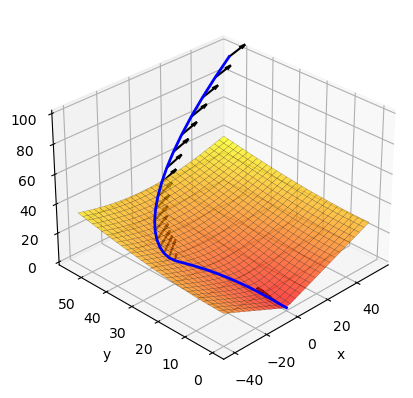

In [6]:
plot(p,f)

## Minimum Time Landing

In [7]:
def check_feasibility(K):
    f = cp.Variable((3,K))
    p = cp.Variable((3,K+1))
    v = cp.Variable((3,K+1))

    const_glide_scope = [p[2,:] >= alpha * cp.norm(p[:2,:], axis=0)]
    const_max_thrust = [cp.norm(f, axis=0) <= Fmax]
    const_p_dynamics = [p[:,1:] == p[:,:-1] + 0.5*h*(v[:,1:] + v[:,:-1])]
    const_v_dynamics = [v[:,1:] == v[:,:-1] + (h/m)*f - h*g*e3]
    const_p_init = [p[:,0] == p0]
    const_v_init = [v[:,0] == v0]
    const_p_fin = [p[:,-1] == 0]
    const_v_fin = [v[:,-1] == 0]

    constraints = const_glide_scope+const_max_thrust+const_p_dynamics+const_v_dynamics+const_p_init+const_v_init+const_p_fin+const_v_fin

    prob = cp.Problem(cp.Minimize(0), constraints)
    prob.solve(solver=cp.ECOS)

    return (p,f), prob.status

In [8]:
low = 1
high = K

current_min = K

while low+1<high:
    k_val = (low+high)//2
    res, status = check_feasibility(k_val)
    if status=='optimal':
        current_min = k_val
        high = k_val
    else:
        low = k_val

print("Minimum Time : ",current_min)

Minimum Time :  25


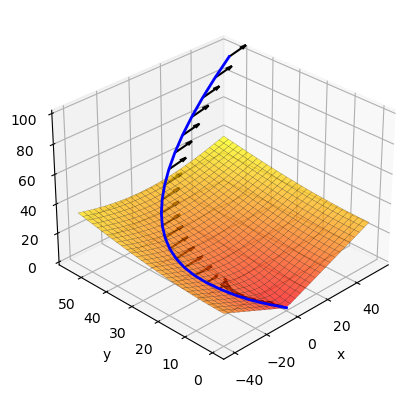

In [9]:
plot(*res)